# Latent Semantic Analysis (LSA)

The LSA is a dimension reduction technique that can be used to uncover common topics in a corpus of text documents.

First of all, we will do a short introduction to singular value decomposition (SVD) and then we will see how to apply LSA to a corpus of text documents.

### Singular Value Decomposition (SVD)

First, a short review of eigenvalues and eigenvectors. Let us see what matrix multiplication actually does. 

Consider a simple $2 \times 2$ matrix $A$ and a 2-dimensional vector $v$:

$$
A = \begin{bmatrix} 1 & 2 \\ 3 & 4 \end{bmatrix}, \quad v = \begin{bmatrix} 1 \\ 1 \end{bmatrix}
$$

When we multiply the matrix $A$ by the vector $v$, we get a new vector $w$:

$$
w = Av = \begin{bmatrix} 1 & 2 \\ 3 & 4 \end{bmatrix} \begin{bmatrix} 1 \\ 1 \end{bmatrix} = \begin{bmatrix} 3 \\ 7 \end{bmatrix}
$$

Let us plot the vectors $v$ and $w$:


The vector w is: [3 7]


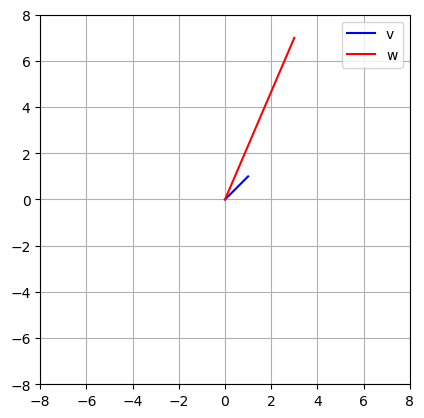

In [4]:
#| label: fig-vector-matrix-product
#| fig-cap: "Original vector v (blue) and the result of the matrix-vector product Av (red)."

import numpy as np
import matplotlib.pyplot as plt

v = np.array([1, 1])
A = np.array([[1, 2], [3, 4]])

w = A @ v
print("The vector w is:", w)

# Plot v and w

plt.plot([0, v[0]], [0, v[1]], 'b', label='v')
plt.plot([0, w[0]], [0, w[1]], 'r', label='w')
plt.axis('square')
plt.axis([-8, 8, -8, 8])
plt.grid()
plt.legend()
plt.show()

From @fig-vector-matrix-product we see that the matrix $A$ has both rotated and scaled the vector $v$ to get the vector $w$. 

For square matrices, there are special vectors. When we multiply these special vectors by the matrix, it acts as a simple scalar multiplication instead of rotating them. These special vectors are called eigenvectors. Because the matrix only scales these vectors, the scaling factor is called the eigenvalue.

$$
A v = \lambda v
$$

where $\lambda$ is the eigenvalue and $v$ is the eigenvector. How to find these special vectors? We can find them by solving the following equation:

$$
(A - \lambda I) v = 0
$$

where $I$ is the identity matrix. There is a result from linear algebra that says that a matrix multiplied by a vector is zero only if the vector is zero or the matrix is singular. If the matrix $A - \lambda I$ is singular, then its determinant is zero. This gives us the eigenvalues.

$$
\text{det}(A - \lambda I) = 0
$$

An interesting result is that if the matrix $A$ is symmetric, then its eigenvectors are orthogonal. To see this, suppose that $v_1$ and $v_2$ are eigenvectors of a symmetric matrix $A$ with eigenvalues $\lambda_1 \neq \lambda_2$.

Because $v_1$ and $v_2$ are eigenvectors, we have:

$$
A v_1 = \lambda_1 v_1, \quad A v_2 = \lambda_2 v_2
$$

If the eigenvectors are orthogonal, then their dot product is zero:

$$
v_1^T v_2 = 0
$$

Because the matrix $A$ is symmetric, we have:

$$
A^T = A
$$

Let's take the dot product as a starting point and try to prove that the eigenvectors are orthogonal. We have:

$$
\lambda_1 v_1^T v_2 = (A v_1)^T v_2 = v_1^T A^T v_2 = v_1^T A v_2 = (A v_1)^T v_2 = \lambda_2 v_1^T v_2
$$

In the end, we get:

$$
(\lambda_1 - \lambda_2) v_1^T v_2 = 0
$$

For this equation to hold, one of the terms must be zero. The first term is the difference of the eigenvalues, which is not zero as we assumed that $\lambda_1 \neq \lambda_2$. Therefore, the second term must be zero:

$$
v_1^T v_2 = 0
$$

This means that the eigenvectors of a symmetric matrix are orthogonal.


In [8]:
# A quick illustration

A = np.array([[1, 2], [2, 1]])
A

array([[1, 2],
       [2, 1]])

In [9]:
# Eigenvalues and eigenvectors

eigenvalues, eigenvectors = np.linalg.eig(A)
print("Eigenvalues:", eigenvalues)
print("Eigenvectors:", eigenvectors)

Eigenvalues: [ 3. -1.]
Eigenvectors: [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


In [11]:
# If the eigenvectors are orthogonal, their dot product is zero

eigenvectors[:, 0].dot(eigenvectors[:, 1])


0.0

In [14]:
# The eigenvectors and eigenvalues of a symmetric matrix are unique up to scaling
# The np.linalg.eig function returns the eigenvectors normalized to have unit length

eigenvectors[:, 0].dot(eigenvectors[:, 0])

0.9999999999999999

## Eigendeomposition

We have just seen that the eigenvectors of a symmetric matrix are orthogonal. Their length is not fixed, but we can normalize them to have a length of 1 (as does `np.linalg.eig`). So we have a set of vectors pointing in different directions and with a length of 1. An amazing result is that we can decompose any matrix into a product of these eigenvectors and eigenvalues. This is called the eigendecomposition:

$$
A = V \Lambda V^T
$$

where $V$ is a matrix with the eigenvectors as columns and $\Lambda$ is a diagonal matrix with the eigenvalues on the diagonal. The matrix $V$ is orthogonal, so its inverse is its transpose.

In [17]:
# If the eigenvectors are orthogonal to each other and normalized to have unit length,
# then the matrix product of the eigenvectors matrix is the identity matrix

eigenvectors @ eigenvectors.T


array([[1., 0.],
       [0., 1.]])

In [32]:
# We can reconstruct the original matrix from its eigenvectors and eigenvalues

A_reconstructed = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
print("Original matrix:")
print(A)
print("Reconstructed matrix:")
print(A_reconstructed)


Original matrix:
[[1 2]
 [2 1]]
Reconstructed matrix:
[[1. 2.]
 [2. 1.]]


In [31]:
# You can think of the reconstructions as adding layers of information to the matrix

eigenvectors[:, 0].reshape(-1, 1)


array([[0.70710678],
       [0.70710678]])

In [1]:
import pandas as pd
import numpy as np
import re
import nltk

nltk.download('reuters')

from nltk.corpus import reuters
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

[nltk_data] Downloading package reuters to /home/amarov/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [2]:
reuters.categories()

['acq',
 'alum',
 'barley',
 'bop',
 'carcass',
 'castor-oil',
 'cocoa',
 'coconut',
 'coconut-oil',
 'coffee',
 'copper',
 'copra-cake',
 'corn',
 'cotton',
 'cotton-oil',
 'cpi',
 'cpu',
 'crude',
 'dfl',
 'dlr',
 'dmk',
 'earn',
 'fuel',
 'gas',
 'gnp',
 'gold',
 'grain',
 'groundnut',
 'groundnut-oil',
 'heat',
 'hog',
 'housing',
 'income',
 'instal-debt',
 'interest',
 'ipi',
 'iron-steel',
 'jet',
 'jobs',
 'l-cattle',
 'lead',
 'lei',
 'lin-oil',
 'livestock',
 'lumber',
 'meal-feed',
 'money-fx',
 'money-supply',
 'naphtha',
 'nat-gas',
 'nickel',
 'nkr',
 'nzdlr',
 'oat',
 'oilseed',
 'orange',
 'palladium',
 'palm-oil',
 'palmkernel',
 'pet-chem',
 'platinum',
 'potato',
 'propane',
 'rand',
 'rape-oil',
 'rapeseed',
 'reserves',
 'retail',
 'rice',
 'rubber',
 'rye',
 'ship',
 'silver',
 'sorghum',
 'soy-meal',
 'soy-oil',
 'soybean',
 'strategic-metal',
 'sugar',
 'sun-meal',
 'sun-oil',
 'sunseed',
 'tea',
 'tin',
 'trade',
 'veg-oil',
 'wheat',
 'wpi',
 'yen',
 'zinc']

In [3]:
housing_fileids = reuters.fileids(["housing"])
income_fileids = reuters.fileids(["income"])
heating_fileids = reuters.fileids(["heat"])

housing_text = reuters.raw(fileids=housing_fileids).split("\n\n")
income_text = reuters.raw(fileids=income_fileids).split("\n\n")
heating_text = reuters.raw(fileids=heating_fileids).split("\n\n")

texts = housing_text + income_text + heating_text
topics = ["housing"] * len(housing_text) + ["income"] * len(income_text) + ["heating"] * len(heating_text)

len(texts)

67

In [4]:
texts[1]

'INTEREST RATES HURT U.S. MAY HOUSING SALES\n  Sales of new single-family homes\n  tumbled 14.9 pct in May from April levels because of higher\n  mortgage interest rates, analysts said.\n      "There should be another month or two of very weak new home\n  sales but with interest rates stabilizing, sale of new homes\n  should become more stable by mid-summer," said economist\n  Lawrence Chimerine of Wharton Econometrics Inc.\n      The drop in May, to a seasonally adjusted annual rate of\n  616,000 units, was the largest since January 1982, the Commerce\n  Department said.\n      Interest rates on conventional mortgages bottomed out at\n  about 9.08 pct in March and rose to about 10.7 pct in April,\n  according to Stephen Roach, economist at Morgan Stanley.\n      The effect was to freeze some potential new homebuyers out\n  of the market, he and others said.\n      "The rates moved very suddenly and were certainly\n  unexpected by homebuyers," said Cynthia Latta, an economist\n  with D

In [5]:
# We will remove the numbers from the text, because here these are very common in every article and obfuscate
# the results

texts = [re.sub("\d+", "", text) for text in texts]

from sklearn.feature_extraction.text import CountVectorizer

tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    min_df=0.05
)
term_doc_matrix = tfidf.fit_transform(texts)

term_doc_df = pd.DataFrame(
    term_doc_matrix.toarray(),
    columns=tfidf.get_feature_names_out()
)

## Should probably remove numbers
term_doc_df.head()

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_8937/761169982.py:4: SyntaxWarning: invalid escape sequence '\d'
  texts = [re.sub("\d+", "", text) for text in texts]


according     added  adjusted  ago  analysts    annual     april  area  \
0   0.056346  0.051617  0.000000  0.0  0.000000  0.041284  0.041284   0.0   
1   0.058931  0.000000  0.037393  0.0  0.058931  0.043178  0.086356   0.0   
2   0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   0.0   
3   0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   0.0   
4   0.000000  0.000000  0.219761  0.0  0.000000  0.042293  0.000000   0.0   

    average      bank  ...  unchanged  underlying      unit    united  \
0  0.080446  0.215250  ...   0.000000     0.00000  0.000000  0.059343   
1  0.000000  0.056281  ...   0.000000     0.05196  0.000000  0.000000   
2  0.000000  0.000000  ...   0.000000     0.00000  0.000000  0.000000   
3  0.000000  0.000000  ...   0.000000     0.00000  0.000000  0.000000   
4  0.000000  0.000000  ...   0.044703     0.00000  0.043455  0.000000   

      units  wage  week      year     years      york  
0  0.040223   0.0   0.0  0.365551  0.059343  0.000000  
1  0.042068   0.0   0.0  0.000000  0.000000  0.044364  
2  0.000000   0.0   0.0  0.000000  0.000000  0.000000  
3  0.000000   0.0   0.0  0.000000  0.000000  0.000000  
4  0.453269   0.0   0.0  0.000000  0.000000  0.000000  

[5 rows x 202 columns]

In [6]:
term_doc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Columns: 202 entries, according to york
dtypes: float64(202)
memory usage: 105.9 KB


$$
A_{m\times n} = \mathbf{U}_{m \times m} \mathbf{\Sigma}_{m \times n} \mathbf{V}^T_{n \times n}
$$
Where $\mathbb{U}$ and $\mathbb{V}$ are orthogonal matrices.

$$
\mathbf{A} = \begin{pmatrix}
u_{11} & u_{12} & \cdots & u_{1m} \\
u_{21} & u_{22} & \cdots & u_{2m} \\
\vdots \\
u_{m1} & u_{m2} & \cdots & u_{mm} \\
\end{pmatrix}
\begin{pmatrix}
\sigma_1 & 0 & \cdots & 0 & 0\\
0 & \sigma_2 & \cdots & 0 & 0\\
0 & 0 & \ddots & \sigma_k & \vdots \\
0 & 0 & \cdots & 0 & \mathbf{0}_{n - k \times m - k}
\end{pmatrix}

\begin{pmatrix}
v_{11} & v_{12} & \cdots & v_{1n} \\
v_{21} & v_{22} & \cdots & v_{2n} \\
\vdots \\
v_{n1} & v_{m2} & \cdots & v_{nn} \\
\end{pmatrix}^T
$$

$$
\begin{align}
\mathbf{A} & = \begin{pmatrix}
u_{11} \\
u_{21} \\
\vdots\\
u_{m1}
\end{pmatrix}
\times \sigma_1 \times 
\begin{pmatrix}
v_{11} & v_{12} & \ldots & v_{1n}
\end{pmatrix} +  \\

& \begin{pmatrix}
u_{12} \\
u_{22} \\
\vdots\\
u_{m2}
\end{pmatrix}
\times \sigma_2 \times 
\begin{pmatrix}
v_{21} & v_{22} & \ldots & v_{2n}
\end{pmatrix} + \\
& \vdots \\
\end{align}
$$

You can think about matrix multiplication as a sum of outer products

$$
\begin{pmatrix}
0 & 1 \\
2 & 3
\end{pmatrix}
\begin{pmatrix}
a & b \\
c & d
\end{pmatrix}
= \begin{pmatrix}
0a & 0b \\
2a & 2b
\end{pmatrix}
+ 
\begin{pmatrix}
1c & 1d \\
3c & 3d
\end{pmatrix} = 
\begin{pmatrix}
0a + 1c & 0b + 1d \\
2a + 3c & 2b + 3d
\end{pmatrix}
$$

Using this you can write the singular value decomposition as a sum of outer products.

$$
\mathbf{A} = \sum_{i} \sigma_i \mathbf{u}_i\mathbf{v}_i^T
$$

While the outer products represent directions, you can think about the singular values as describing the _importance_ of these directions.

Some of the terms in the sum contribute less to A, so dropping these from the sum results in a lower-rank (p) approximation of the matrix.

$$
\mathbf{A} \approx \sum_{i = 1}^{p} \sigma_i \mathbf{u}_i\mathbf{v}_i^T
$$




Example document-term matrix:

| Documents/Terms | house | oil  | wage |
|-----------------|-------|------|------|
| Doc1 (housing)  | 1.43  | 0.02 | 0.3  |
| Doc2 (income)   | 0.4   | 0.01 | 1.2  |
| Doc3 (heat)     | 0.35  | 1.7  | 0.04 |

Example terms-topic matrix: values indicate how strongly a word is related to a topic.

| Word/Topic | housing | income | heat |
|------------|---------|--------|------|
| house      | 1.43    | 0.022  | 0.34 |
| wage       | 0.14    | 2.01   | 0.25 |
| oil        | 0.35    | 0.21   | 1.12 |

Example document-topic matrix: the values in this matrix indicate how strongly
a document is related to a topic.

| Document/Topic | housing | income | heat |
|----------------|---------|--------|------|
| Doc1 (housing) | 1.43    | 0.01   | 0.21 |
| Doc2 (income)  | 0.14    | 2      | 0.25 |
| Doc3 (heat)    | 0.38    | 0.21   | 1.17 |


The singular values indicate how strongly a topic contributes to explaining
the data (term-document frequencies).

| Topic   | singular value |
|---------|----------------|
| housing | 6.2            |
| wage    | 2.3            |
| oil     | 0.02           |


In [7]:
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=30, n_iter=100, random_state=42)
lsa_result = lsa.fit_transform(term_doc_df)
Sigma = lsa.singular_values_
V_T = lsa.components_.T
V_T

array([[ 0.01101562,  0.02439823, -0.00161363, ..., -0.02487008,
        -0.01906654, -0.01775292],
       [ 0.01683061,  0.00145462, -0.016919  , ..., -0.01384861,
        -0.01824396,  0.02444552],
       [ 0.10548801, -0.02915534,  0.11419569, ..., -0.04158702,
        -0.1313619 ,  0.00392041],
       ...,
       [ 0.15972607, -0.02640216, -0.08136184, ...,  0.0724007 ,
         0.17677594,  0.05606418],
       [ 0.01335311,  0.0091913 , -0.00876963, ...,  0.01770479,
        -0.03152487,  0.02959704],
       [ 0.02667957,  0.14944649,  0.00880958, ..., -0.07018896,
        -0.04003199,  0.00985056]])

<Axes: >

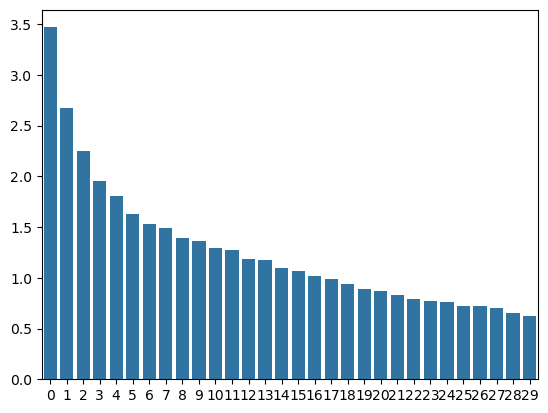

In [8]:
sns.barplot(x=list(range(len(Sigma))), y = Sigma)

In [9]:
term_topic_matrix = pd.DataFrame(data=V_T,
                                 index=term_doc_df.columns,
                                 columns = [f'Component {r}' for r in range(0,V_T.shape[1])])
term_topic_matrix

Component 0  Component 1  Component 2  Component 3  Component 4  \
according     0.011016     0.024398    -0.001614     0.008535    -0.009180   
added         0.016831     0.001455    -0.016919     0.007546    -0.023014   
adjusted      0.105488    -0.029155     0.114196    -0.037458    -0.085096   
ago           0.020690     0.001509    -0.013194    -0.003925    -0.023187   
analysts      0.019367     0.014118    -0.002075     0.000837    -0.027660   
...                ...          ...          ...          ...          ...   
wage          0.036213    -0.006499    -0.067636    -0.088962    -0.006264   
week          0.025413     0.038685    -0.000160     0.006536    -0.026049   
year          0.159726    -0.026402    -0.081362    -0.043734    -0.063589   
years         0.013353     0.009191    -0.008770     0.021923    -0.000794   
york          0.026680     0.149446     0.008810    -0.005014     0.015836   

           Component 5  Component 6  Component 7  Component 8  Component 9  \
according     0.028410    -0.009367    -0.028593     0.054321    -0.014011   
added         0.021992    -0.031480    -0.037103     0.012437     0.009522   
adjusted     -0.045588    -0.041630     0.044755    -0.014731     0.025389   
ago           0.004307     0.003622    -0.001829    -0.006370     0.032890   
analysts      0.063290    -0.004396    -0.054687     0.091456     0.008507   
...                ...          ...          ...          ...          ...   
wage         -0.016005     0.026172    -0.031241     0.005113    -0.148983   
week          0.071830     0.000728    -0.054469     0.106938     0.012066   
year          0.136046    -0.332106    -0.184065    -0.107725     0.026610   
years         0.020382    -0.033321    -0.003943    -0.024872    -0.014972   
york          0.010988     0.014756    -0.006689     0.018373    -0.014348   

           ...  Component 20  Component 21  Component 22  Component 23  \
according  ...      0.123077     -0.059647      0.081321      0.108827   
added      ...      0.023162      0.057442      0.014347      0.003134   
adjusted   ...     -0.058722      0.041000      0.035087      0.080478   
ago        ...      0.013501     -0.022060     -0.052997     -0.007442   
analysts   ...      0.201333      0.142167      0.037377     -0.102600   
...        ...           ...           ...           ...           ...   
wage       ...     -0.029038      0.127954      0.038232      0.062789   
week       ...      0.179050      0.076547     -0.021056     -0.100622   
year       ...      0.034884     -0.083444      0.118945     -0.062420   
years      ...     -0.010101      0.054964     -0.093024     -0.053463   
york       ...     -0.073071     -0.032199      0.082060      0.001370   

           Component 24  Component 25  Component 26  Component 27  \
according      0.103682     -0.026132      0.086406     -0.024870   
added         -0.028848     -0.017090      0.015291     -0.013849   
adjusted       0.063575      0.015637     -0.001009     -0.041587   
ago           -0.023022     -0.016295      0.082894      0.009509   
analysts       0.129020      0.025406      0.007310     -0.046779   
...                 ...           ...           ...           ...   
wage          -0.034565      0.022911     -0.008388     -0.062696   
week           0.181238     -0.013838      0.003907      0.020974   
year           0.042034      0.088592     -0.084694      0.072401   
years          0.011144      0.012792      0.187997      0.017705   
york           0.016474     -0.080595     -0.012585     -0.070189   

           Component 28  Component 29  
according     -0.019067     -0.017753  
added         -0.018244      0.024446  
adjusted      -0.131362      0.003920  
ago           -0.009192      0.004566  
analysts       0.032218     -0.038021  
...                 ...           ...  
wage           0.027726     -0.008366  
week           0.020679      0.010763  
year           0.176776      0.056064  
years         -0.03

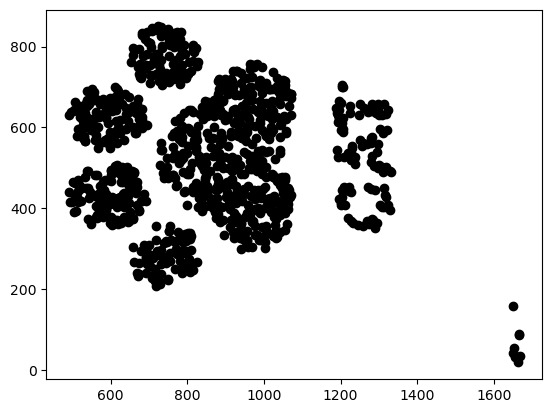

In [22]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Load the WebP image as black and white

image_path = '../figures/istockphoto-1194128644-2048x2048.webp'
image = Image.open(image_path).convert('1')

# Select the left half of the image

left_half = image.crop((0, 0, image.width // 2, image.height))

image_left = np.array(left_half)
df = pd.DataFrame(image_left)

df_l = df.stack().reset_index()
df_black = df_l[df_l[0] == False].sample(1000)
df_black.columns = ['x', 'y', 'black']
df_black["z"] = np.random.randn(len(df_black))

plt.plot(df_black['x'], df_black['y'], 'o', color='black')


In [23]:
# Plotly create a 3D scatter plot
fig = px.scatter_3d(df_black, x='x', y='y', z='z', size_max=3)
fig.update_traces(marker=dict(size=3))  # Reduce the size of the points
fig.show()

In [37]:
lsa = TruncatedSVD(n_components=3)
lsa_result = lsa.fit_transform(df_black[['x', 'y', 'z']])
Sigma = lsa.singular_values_
V_T = lsa.components_.T

<Axes: >

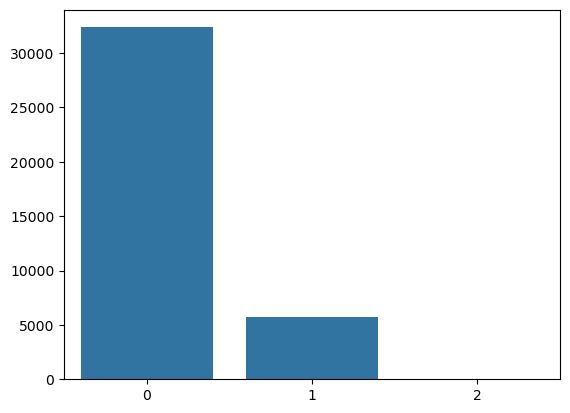

In [38]:
sns.barplot(x=list(range(len(Sigma))), y = Sigma)

In [39]:
lsa_result.shape

(1000, 3)

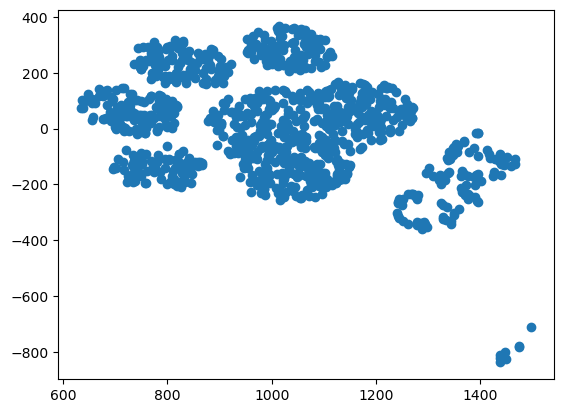

In [40]:
# Plot the first two components of the last SVD

plt.scatter(lsa_result[:, 0], lsa_result[:, 1])